# Parametric and semi parametric models

In [304]:
import pandas as pd
import numpy as np

- In this class we are going to use the data we prepared last class, to develop models that predict properties prices in Bogotá


In [308]:
data=pd.read_pickle('data_ejemplo.pkl')

In [306]:
data=data.reset_index(drop=True)

In [309]:
data=data[['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price','l4_Zona Centro', 'l4_Zona Chapinero', 'l4_Zona Noroccidental',
       'l4_Zona Norte', 'l4_Zona Occidental', 'l4_Zona Sur',
       'l4_Zona Suroccidental', 'l5_Antonio Nariño', 'l5_Barrios Unidos',
       'l5_Bosa','elevator']]

- **[Linear regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model 70-30 validation approach**

In [310]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [157]:
y_train=data['price'][:116858]
x_train=data.drop(columns=['price'])[:116858]
y_test=data['price'][116858:]
x_test=data.drop(columns=['price'])[116858:]

In [336]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=['price']),data['price'], test_size=0.30,
                                                    random_state=200,
                                                    shuffle=True)

In [337]:
reg = LinearRegression().fit(x_train, y_train)

In [161]:
mse(y_test, reg.predict(x_test))

3.2617442882508406e+18

- **Linear regression model k-fold cross validation (k=10)**

In [162]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error as mse

In [317]:
folds = KFold(n_splits = 10, shuffle = True, random_state = 100)
hyper_params = [{'n_features_to_select': list(range(1, 18))}]
lm = LinearRegression()
lm.fit(x_train, y_train)
rfe = RFE(lm)  
            
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'neg_mean_squared_error', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True
                       ,n_jobs=10)      
bla=model_cv.fit(x_train, y_train)  

Fitting 10 folds for each of 17 candidates, totalling 170 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   11.6s
[Parallel(n_jobs=10)]: Done 170 out of 170 | elapsed:   45.5s finished


In [318]:
mse(y_test, bla.predict(x_test))

3.0389601724683177e+18

**polynomial regression**

In [180]:
from sklearn.preprocessing import PolynomialFeatures

In [198]:
data2=data[['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total','surface_covered', 'price']]

In [320]:
poly = PolynomialFeatures(2)
X=poly.fit_transform(data2.drop(columns=['price']))
Y=data2['price'].to_numpy()

In [322]:
x2_train, x2_test, y2_train, y2_test = train_test_split(X,data2['price'], test_size=0.30,
                                                    random_state=200,
                                                    shuffle=True)

In [323]:
reg_pol = LinearRegression().fit(x2_train, y2_train)

In [324]:
mse(y2_test, reg_pol.predict(x2_test))

3.1434362732854043e+21

In [325]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
hyper_params = [{'n_features_to_select': list(range(1, 36))}]
lm = LinearRegression()
lm.fit(x2_train, y2_train)
rfe = RFE(lm)  
            
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'neg_mean_squared_error', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True
                       ,n_jobs=10)      
poly_cv=model_cv.fit(x2_train, y2_train)  
mse(y2_test, poly_cv.predict(x2_test))

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   46.4s
[Parallel(n_jobs=10)]: Done 175 out of 175 | elapsed:  2.8min finished


3.133779825062958e+18

-The prediction get´s better, but is worst than the prediction with the aditional dummy variables

**Step functions and splines**

In [225]:
from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

- Let's see an spline example only with one feature. In this example we will supouse there is reason to belive the relation bewteen the surface area and the price of an aparment is not linear. 

In [266]:
spline=data[(data['surface_total']!=0)&(data['surface_total']<1000)]

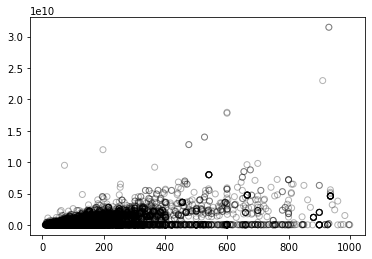

In [269]:
plt.scatter(spline.surface_total,spline.price, facecolor='None', edgecolor='k', alpha=0.3)

In [274]:
transformed_x = dmatrix("bs(spline.surface_total, knots=(10,400,800), degree=0, include_intercept=False)",
                        {"spline.surface_total": spline.surface_total}, return_type='dataframe')

In [327]:
fit4 = sm.GLM(spline.price, transformed_x).fit()

In [328]:
surface_total_grid = np.arange(spline.surface_total.min(), spline.surface_total.max()).reshape(-1,1)

In [329]:
pred4 = fit4.predict(dmatrix("bs(surface_total_grid, knots=(10,400,800), degree=0, include_intercept=False)",
                             {"surface_total_grid": surface_total_grid}, return_type='dataframe'))

[Text(0, 0.5, 'price'),
 Text(0.5, 0, 'surface_total'),
 Text(0.5, 1.0, 'Spline degree=0')]

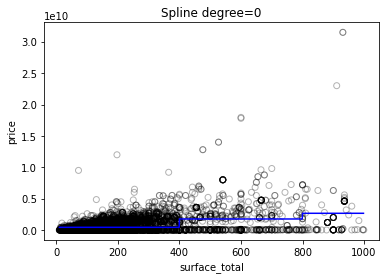

In [295]:
fig, ax = plt.subplots()


ax.scatter(spline.surface_total,spline.price, facecolor='None', edgecolor='k', alpha=0.3)
ax.plot(surface_total_grid, pred4, color='b')
ax.set(xlabel='surface_total', ylabel='price',
       title='Spline degree=0')





In [297]:
transformed_x1 = dmatrix("bs(spline.surface_total, knots=(10,400,800), degree=3, include_intercept=False)",
                        {"spline.surface_total": spline.surface_total}, return_type='dataframe')


In [298]:
fit41 = sm.GLM(spline.price, transformed_x1).fit()
pred5 = fit41.predict(dmatrix("bs(surface_total_grid, knots=(10,400,800), degree=3, include_intercept=False)",
                             {"surface_total_grid": surface_total_grid}, return_type='dataframe'))

[Text(0, 0.5, 'price'),
 Text(0.5, 0, 'surface_total'),
 Text(0.5, 1.0, 'Spline degree=3')]

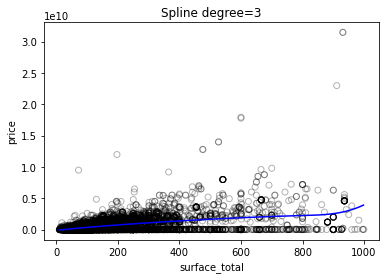

In [300]:
fig, ax = plt.subplots()


ax.scatter(spline.surface_total,spline.price, facecolor='None', edgecolor='k', alpha=0.3)
ax.plot(surface_total_grid, pred5, color='b')
ax.set(xlabel='surface_total', ylabel='price',
       title='Spline degree=3')

**[Decision Tree](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html) Regression**

In [330]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

In [331]:
simple_tree=DecisionTreeRegressor(max_depth=3).fit(x_train, y_train)
mse(y_test, simple_tree.predict(x_test))

2.934116443017379e+18

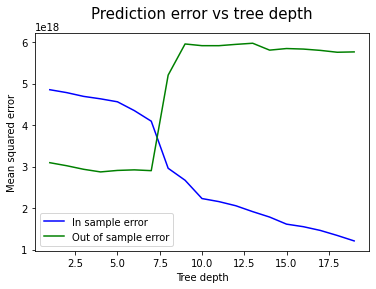

In [166]:
depth = range(1, 20)
in_sample_error= []
out_of_sample_error = []
for n in depth: 
    tree=DecisionTreeRegressor(max_depth=n).fit(x_train, y_train)
    in_sample_error.append(mse(y_train, tree.predict(x_train)))
    out_of_sample_error.append(mse(y_test, tree.predict(x_test)))
plt.plot(depth, in_sample_error, color='blue', label='In sample error')
plt.plot(depth, out_of_sample_error, color='green', label='Out of sample error')
plt.xlabel('Tree depth')
plt.ylabel('Mean squared error')
plt.title('Prediction error vs tree depth', pad=15, size=15)
plt.legend()

- We can see that when the depth parameter is bigger than 7, the in sample error is smaller and dthe out is sample error is smaller, this can be explained because the model is overfitting to the training data

In [332]:
simple_tree=DecisionTreeRegressor(max_depth=7).fit(x_train, y_train)
mse(y_test, simple_tree.predict(x_test))

2.8992828922023956e+18

In [333]:
model = DecisionTreeRegressor()

gs = GridSearchCV(model,
                  param_grid = {'max_depth': range(1, 20)},
                  cv=10,
                  n_jobs=10,
                  scoring='neg_mean_squared_error')

cv_tree=gs.fit(x_train, y_train)

In [334]:
mse(y_test, cv_tree.predict(x_test))

2.8767714298872387e+18